# Canopy Wave demo

## Configuration

In [1]:
# Enable module autoreload
%load_ext autoreload
%autoreload 2

# Directories
script_dir = '/home/jovyan/work'
data_dir = '/home/jovyan/work/resources'

## Imports

In [26]:
# Standard
import datetime
import json
import os.path
import sys

# Third-party
import matplotlib.pyplot as plt
import numpy as np

# Custom
sys.path.append(script_dir)  # Path to the canopywave scripts
import canopywaves as cw

## Create a CanopyWaveCase

Here we assume that a JSON file containing all necessary info to create the cases is available.

In [9]:
# Load JSON data
json_file = os.path.join(data_dir, 'canopywave_cases.json')
with open(json_file, 'r') as f:
    json_data = json.load(f)
       
# Pick a case, get info from JSON data   
case_id = 11
json_id = str(case_id)  # In the JSON file, IDs are written as strings
case_start = datetime.datetime.strptime(
    json_data[json_id]['datetime_start'],
    '%Y-%m-%d %H:%M:%S',
    )
case_stop = datetime.datetime.strptime(
    json_data[json_id]['datetime_stop'],
    '%Y-%m-%d %H:%M:%S',
    )
case_bscans = [os.path.join(data_dir, 'bscans', s) for s in json_data[json_id]['bscans']]

# Create the CanopyWaveCase instance
wavecase = cw.CanopyWaveCase(case_id, case_start, case_stop, case_bscans)
print(wavecase)

CanopyWaveCase #11
	data: 2007-04-24 13:00:22 - 2007-04-24 13:02:11 UTC (10 scans)
	grid: [-200.0, 202.0]x[-1810.0, -1408.0] m^2 (201x201 pixel^2 @ 2.0 m/pixel)


## Load scan data

Note: this can take some time when GPU-accelerated functions are not available.

In [15]:
wavecase.load_scan_data()

* (Case #11) Loading scan data
File /home/jovyan/work/resources/bscans/REAL.20070424_130032.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130043.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130054.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130105.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130116.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130126.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 record

## Compute global hard-target mask

This mask is computed using all scans from the sequence, based on a simple value threshold.

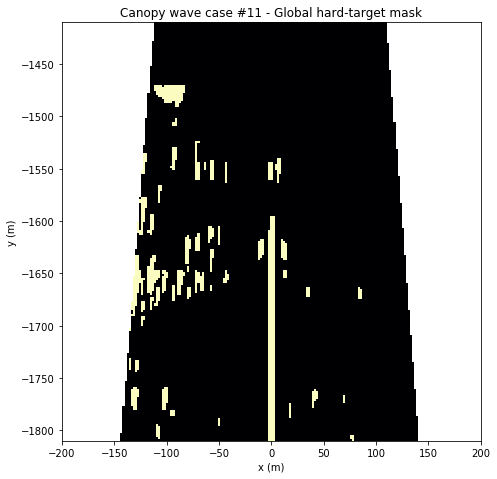

In [47]:
# Compute mask
hard_target_mask = wavecase.hard_target_mask(threshold=3.)

# Display
fig, ax = plt.subplots(figsize=(7.5, 8))
ax.imshow(
    np.ma.array(hard_target_mask, mask=wavecase.grid_global_mask),
    interpolation='nearest',
    cmap='magma',
    vmin=0,
    vmax=0.5,
    origin='bottom',
    extent=[wavecase.x[0], wavecase.x[-1], wavecase.y[0], wavecase.y[-1]],
    )
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f'Canopy wave case #{wavecase.case_id:02d} - Global hard-target mask')
plt.show()

## Display sample scan

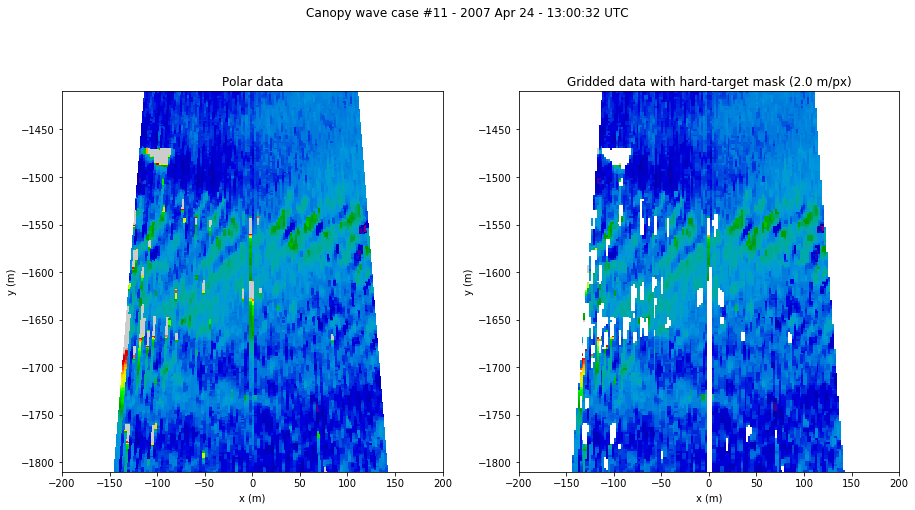

In [52]:
# Pick scan
scan_idx = 0
scan_data = wavecase.scan_data[scan_idx]  # Original (preprocessed) polar data
grid_scan = wavecase.grid_scans[scan_idx]  # Gridded data
grid_mask = wavecase.grid_masks[scan_idx]  # Grid mask
full_mask = np.logical_or(hard_target_mask, grid_mask)

# Create figure
fig, axes = plt.subplots(1,2, figsize=(15, 8))
axp, axc = axes  # Polar, Cartesian
# Polar data
axp.set_title('Polar data')
axp.set_aspect('equal')  # Force same scale on x, y axes
p0 = axp.pcolormesh(
    scan_data['x'],
    scan_data['y'],
    scan_data['scan'],
    cmap='nipy_spectral',
    vmin=-1,
    vmax=3
    )
# Gridded data
axc.set_title('Gridded data with hard-target mask ({} m/px)'.format(
    wavecase.param_grid["resolution"]))
p1 = axc.imshow(
    np.ma.array(grid_scan, mask=full_mask),
    interpolation='nearest',
    cmap='nipy_spectral',
    vmin=-1.,
    vmax=3.,
    origin='bottom',
    extent=[wavecase.x[0], wavecase.x[-1], wavecase.y[0], wavecase.y[-1]],
    )
# Tune axes
for ax in axes:
    ax.set_xlim(xmin=wavecase.x[0], xmax=wavecase.x[-1])
    ax.set_ylim(ymin=wavecase.y[0], ymax=wavecase.y[-1])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
# Add global title
plt.figtext(
    0.5,
    0.98,
    'Canopy wave case #{:02d} - {:%Y %b %d - %H:%M:%S} UTC'.format(
        wavecase.case_id, scan_data['time'][0]),
    ha='center',
    va='top',
    size='large',
    )    
plt.show()


## Estimate wave parameters

Note: this will take some time.

In [61]:
# Estimate wave parameters (wavelength, crest orientation) for each scan,
# as well as the "mean" wave (across scans)
waves, mean_wave = wavecase.wave_parameters()
for idx, wave in enumerate(waves):
    print('[{idx}] Wavelength: {wavelength:.1f} m, crest direction: {crest_direction:.0f} deg'.format(
        idx=idx, **wave))

[0] Wavelength: 21.0 m, crest direction: 37 deg
[1] Wavelength: 23.0 m, crest direction: 38 deg
[2] Wavelength: 25.0 m, crest direction: 40 deg
[3] Wavelength: 23.0 m, crest direction: 39 deg
[4] Wavelength: 23.0 m, crest direction: 37 deg
[5] Wavelength: 23.0 m, crest direction: 37 deg
[6] Wavelength: 25.0 m, crest direction: 36 deg
[7] Wavelength: 25.0 m, crest direction: 37 deg
[8] Wavelength: 25.0 m, crest direction: 35 deg
[9] Wavelength: 27.0 m, crest direction: 34 deg


[0] Wavelength: 21.0 m, crest direction: 37 deg
[1] Wavelength: 23.0 m, crest direction: 38 deg
[2] Wavelength: 25.0 m, crest direction: 40 deg
[3] Wavelength: 23.0 m, crest direction: 39 deg
[4] Wavelength: 23.0 m, crest direction: 37 deg
[5] Wavelength: 23.0 m, crest direction: 37 deg
[6] Wavelength: 25.0 m, crest direction: 36 deg
[7] Wavelength: 25.0 m, crest direction: 37 deg
[8] Wavelength: 25.0 m, crest direction: 35 deg
[9] Wavelength: 27.0 m, crest direction: 34 deg
